# Wet Bulb Calculation Analysis
## Common/Helper Methods

In [1]:
%matplotlib inline

import math
from numpy import *
import matplotlib.pyplot as plt
from matplotlib import cm
from pylab import *
from operator import itemgetter

import hygrometry

def frange(x, y, jump):
    """Like range(), but works with floats."""
    x=float(x)
    y=float(y)
    jump = float(jump)
    while x < y:
        yield x
        x += jump


In [2]:
def plot2derrors(all_maxerrors):
    mmap=[{}, {}, {}]
    
    for i in range(0, len(all_maxerrors[0])):
        for j in [0, 1, 2]:
            key="%.1f" % (all_maxerrors[j][i],)
            if key in mmap[j]:
                if mmap[j][key][1] < all_maxerrors[3][i]:
                    mmap[j][key] = [all_maxerrors[j][i], all_maxerrors[3][i]]
            else:
                mmap[j][key] = [all_maxerrors[j][i], all_maxerrors[3][i]]
    
    xl=['T', 'H', 'P']        
    for j in [0, 1, 2]:
        X=[]
        Y=[]
        for key in mmap[j]:
            X.append(mmap[j][key][0])
            Y.append(mmap[j][key][1])
        X, Y = [list(x) for x in zip(*sorted(zip(X, Y), key=lambda pair: pair[0]))]    
        figure()
        
        plot(X, Y, 'r')
        xlabel(xl[j])
        ylabel('max(E)')
        show()


In [3]:
def calc_maxerrors(wet_bulb_calc_func, sensor_range, sensor_errors, steps, pressure_sensor=True, pressure_constant=977):
    tidx=0
    rhidx=1
    pidx=2
        
    merr = 0
    minfo = []

    all_maxerrors = [[], [], [], []]
    count = 0.0
    mserr = 0.0
    for Tc in frange(sensor_range[tidx][0], sensor_range[tidx][1], steps[tidx]):
        for P in frange(sensor_range[pidx][0], sensor_range[pidx][1], steps[pidx]):
            for RH in frange(sensor_range[rhidx][0], sensor_range[rhidx][1], steps[rhidx]):
                sterr = 0
                Ptruth=P
                if not pressure_sensor:
                    Ptruth=pressure_constant
                st = [Tc, RH, P]
                truth = wet_bulb_calc_func(Tc, RH, Ptruth)
                
                eTc=sensor_errors[tidx](Tc)
                eRH=sensor_errors[rhidx](RH)
                eP=sensor_errors[pidx](P)

                
                combos = [[eTc, 0, 0], [-eTc, 0, 0], \
                          [0, eRH, 0], [0, -eRH, 0], \
                          [0, 0, eP], [0, 0, -eP], \
                          [eTc, eRH, 0], [eTc, -eRH, 0], [-eTc, eRH, 0], [-eTc, -eRH, 0], \
                          [eTc, 0, eP], [eTc, 0, -eP], [-eTc, 0, eP], [-eTc, 0, -eP], \
                          [0, eRH, eP], [0, eRH, -eP], [0, -eRH, eP], [0, -eRH, -eP], \
                          [eTc, eRH, eP], [eTc, -eRH, eP], [eTc, -eRH, -eP],\
                          [-eTc, eRH, eP], [-eTc, -eRH, eP], [-eTc, -eRH, -eP]]
            
                for c in combos:
                    tmp = wet_bulb_calc_func(Tc+c[0], RH+c[1], P+c[2])
                    nerr = math.fabs(truth-tmp)
                    mserr += nerr
                    count += 1.0
                    if nerr > merr:
                        merr = nerr
                        minfo = [merr, [Tc, RH, P], c]
                    if nerr > sterr:
                        sterr = nerr
                all_maxerrors[0].append(Tc)
                all_maxerrors[1].append(RH)
                all_maxerrors[2].append(P)
                all_maxerrors[3].append(sterr)
    mserr=mserr/count
    minfo.append(mserr)

    return [minfo, all_maxerrors]
    

In [4]:
def calc_uncertainty(wet_bulb_calc_func, sensor_range, sensor_errors, steps, pressure_sensor=True, pressure_constant=977):
    tidx=0
    rhidx=1
    pidx=2
    
    
    merr = 0
    minfo = []
    h=0.01
    h_T=h
    h_RH=h
    h_P=h
    all_maxerrors = [[], [], [], []]
    for Tc in frange(sensor_range[tidx][0], sensor_range[tidx][1], steps[tidx]):
        for RH in frange(sensor_range[rhidx][0], sensor_range[rhidx][1], steps[rhidx]):
            for P in frange(sensor_range[pidx][0], sensor_range[pidx][1], steps[pidx]):
                if not pressure_sensor:
                    eP=math.fabs(P-pressure_constant)
                #eP=0
                eTc=sensor_errors[tidx](Tc)
                eRH=sensor_errors[rhidx](RH)
                eP=sensor_errors[pidx](P)

                
                dTc_dF=(wet_bulb_calc_func(Tc+h_T, RH, P) - wet_bulb_calc_func(Tc-h_T, RH, P))/(2.0*h_T)
                dRH_dF=(wet_bulb_calc_func(Tc, RH+h_RH, P) - wet_bulb_calc_func(Tc, RH-h_RH, P))/(2.0*h_RH)
                dP_dF=(wet_bulb_calc_func(Tc, RH, P+h_P) - wet_bulb_calc_func(Tc, RH, P-h_P))/(2.0*h_P)
                dF = math.sqrt( (dTc_dF*eTc)**2.0 + (dRH_dF*eRH)**2.0 + (dP_dF*eP)**2.0 )
                
                if dF > merr:
                    merr = dF
                    minfo = [merr, [Tc, RH, P]]
                all_maxerrors[0].append(Tc)
                all_maxerrors[1].append(RH)
                all_maxerrors[2].append(P)
                all_maxerrors[3].append(dF)
    return [minfo, all_maxerrors]
    

In [5]:
def batch_WB(wet_bulb_func, range_t, range_rh, range_p):
    ret = []
    for Tc in frange(range_t[0], range_t[1], range_t[2]):
        for RH in frange(range_rh[0], range_rh[1], range_rh[2]):
            for P in frange(range_p[0], range_p[1], range_p[2]):
                value = wet_bulb_func(Tc, RH, P)
                ret.append([Tc, RH, P, value])
    return ret


## Ranges and Sensor Accuracy

Analysis Assumptions:
* Temperatures range from 85F - 110F
* Pressures range in the from 904 hPa - 1050 hPa
* RH in from 20% - 100%

Example sensor to show error propgation will be the SHT-75.


In [6]:
range_Tc = [hygrometry.conv_F2C(85.), hygrometry.conv_F2C(110.)]
range_P = [904., 1050.]
range_RH = [20., 100.]
srange=[range_Tc, range_RH, range_P]

### Sensor Errors


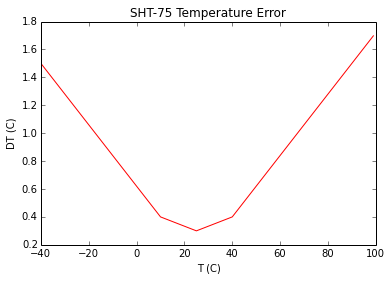

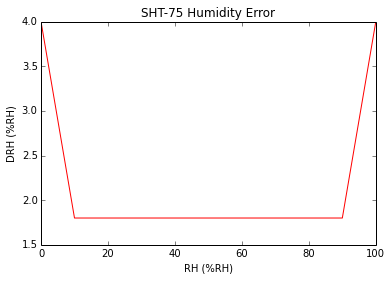

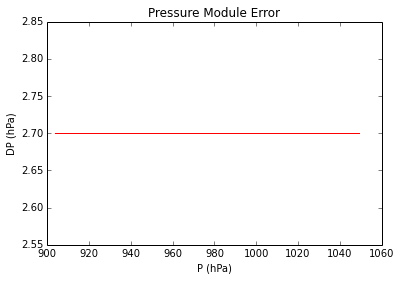

In [7]:

#These errors are from SHT75 datasheet, Figure 2 and Figure 3
def error_Tc(Tc):
    #-40C - 10
    if Tc <= 10:
        return (-1.1/50.)*(Tc-10) + 0.4
    #10C - 25C
    elif Tc <= 25:
        return (-0.1/15.)*(Tc-25) + 0.3
    #25C - 40C
    elif Tc <= 40:
        return (0.1/15.)*(Tc-25) + 0.3
    #40C - 100C
    elif Tc <= 100:
        return (1.1/50.)*(Tc-40) + 0.4
    else:
        return Inf
#These errors are from SHT75 datasheet
def error_RH(RH):
    if RH >= 10.0 and RH <= 90:
        return 1.8
    elif RH < 10.0:
        return (-2.2/10.0)*(RH-10.0) + 1.8
    else:
        return (2.2/10.0)*(RH-90.0) + 1.8

#TODO: Look at pressure datasheet and our calculations some more.        
def error_P(P):
    return 2.7

#Plot sensor errors
figure()
T = []
DT = []
for t in frange(-40., 100., 1):
    T.append(t)
    DT.append(error_Tc(t))
plot(T, DT, 'r')
xlabel('T (C)')
ylabel('DT (C)')
title('SHT-75 Temperature Error')
show()

figure()
RH = []
DRH = []
for rh in frange(0., 101., 1):
    RH.append(rh)
    DRH.append(error_RH(rh))
plot(RH, DRH, 'r')
xlabel('RH (%RH)')
ylabel('DRH (%RH)')
title('SHT-75 Humidity Error')
show()


figure()
P = []
DP = []
for p in frange(range_P[0], range_P[1], 1):
    P.append(p)
    DP.append(error_P(p))
plot(P, DP, 'r')
xlabel('P (hPa)')
ylabel('DP (hPa)')
title('Pressure Module Error')
show()


# Tim Brice and Todd Hall Wet Bulb calculation

* Original Javascript version: http://www.srh.noaa.gov/epz/?n=wxcalc_rh
* Easy Calculation tries to explian it: https://www.easycalculation.com/weather/learn-dewpoint-wetbulb.php

vapor pressure, saturation vapor pressure, dew point:
$$ es = 6.112 \cdot e^{\frac{17.67 \cdot T_c}{T_c+243.5}} $$
$$ V = \frac{es \cdot RH}{100} $$
$$ T_d = \frac{243.5 \cdot \ln(V/6.112)}{17.67 - \ln(V/6.112)} $$


Then sent to some incremental loop function, calc_wb()

## Error and Stability NOAA

### Forward Stability

In [8]:
print (hygrometry.calc_sWB(20, 0, 985) - 5.85) < 0.01
print (hygrometry.calc_sWB(20, 0, 985) - 20.) < 0.01
print math.fabs(hygrometry.calc_sWB(20, 50, 985) - 13.8) < 0.01
print (hygrometry.calc_sWB(30, 25, 985) - 16.92) < 0.01
print (hygrometry.calc_sWB(40, 50, 3) - 27.67) < 0.01
print (hygrometry.calc_sWB(41.3, 24.2, 351.6) - 20.5) < 0.01
print (hygrometry.calc_sWB(22.9, 81.2, 476.1) - 20.12) < 0.01
print (hygrometry.calc_sWB(41.2, 24, 900) - 23.83) < 0.01
print math.fabs(hygrometry.calc_sWB(41, 12, 1000) - 20.08) < 0.01 

True
True
True
True
True
True
True
True
True


#### Max Error Propagation

[1.1222000000000065, [43.244467999999905, 99.1999999999999, 904.0], [-0.4713782959999979, -3.8239999999999794, -2.7], 0.35287377978370743]
Max error: 1.122200


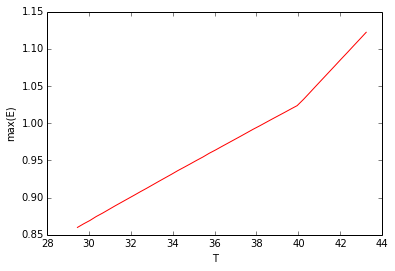

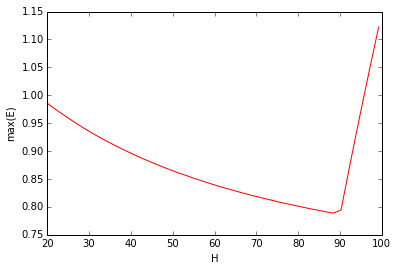

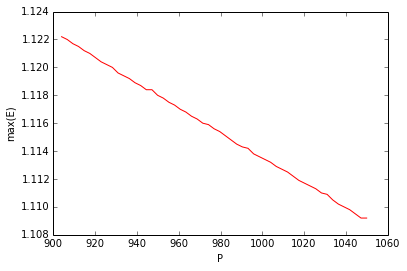

In [9]:
step_Tc = 0.3
step_RH = 1.8
step_P = 2.7
ssteps=[step_Tc, step_RH, step_P]
info, errs = calc_maxerrors(hygrometry.calc_sWB, srange, [error_Tc, error_RH, error_P], ssteps, True)
print info
print "Max error: %f" % (info[0],)
plot2derrors(errs)

#### Max Error Table

In [10]:

print "      RH/Temperature Wet Bulb Error Table in Celsius"
print "T\RH| ",
for xh in frange(0., 101., 10.):
    print " %-3s " % ("%d" % (xh,),),
print
print "-"*(11*6)+"------",

frow = True
for y in frange(0., 51., 5.):
    print
    print "%-3s | " % ("%d" % (y,),),    
    for x in frange(0., 101., 10.):
        info, errs = calc_maxerrors(hygrometry.calc_sWB, [[y, y+1], [x, x+1], [904.0, 1050.0]], [error_Tc, error_RH, error_P], [5, 10, 2.7], True)
        merr = array(errs[3]).max()
        print "%.2f " % (merr,),
print



      RH/Temperature Wet Bulb Error Table in Celsius
T\RH|   0     10    20    30    40    50    60    70    80    90    100 
------------------------------------------------------------------------
0   |  0.72  0.58  0.60  0.62  0.64  0.65  0.67  0.69  0.70  0.72  0.86 
5   |  0.71  0.52  0.54  0.56  0.57  0.58  0.60  0.61  0.62  0.63  0.80 
10  |  0.73  0.48  0.49  0.50  0.51  0.52  0.53  0.54  0.54  0.55  0.75 
15  |  0.83  0.50  0.51  0.52  0.53  0.53  0.54  0.54  0.54  0.54  0.77 
20  |  0.96  0.54  0.54  0.54  0.54  0.54  0.54  0.54  0.54  0.54  0.79 
25  |  1.13  0.59  0.58  0.57  0.57  0.56  0.55  0.54  0.54  0.53  0.81 
30  |  1.37  0.69  0.67  0.66  0.64  0.63  0.62  0.61  0.60  0.59  0.89 
35  |  1.65  0.81  0.77  0.75  0.72  0.70  0.69  0.67  0.66  0.65  0.97 
40  |  1.97  0.94  0.88  0.84  0.80  0.78  0.75  0.73  0.72  0.70  1.05 
45  |  2.38  1.12  1.04  0.99  0.95  0.91  0.89  0.86  0.85  0.83  1.20 
50  |  2.85  1.31  1.21  1.14  1.09  1.05  1.02  1.00  0.98  0.96  1.35

In [11]:
print "      RH/Temperature Wet Bulb Error Table in Fahrenheit"
print "T\RH| ",
for xh in frange(0., 101., 10.):
    print " %-3s " % ("%d" % (xh,),),
print
print "-"*(11*6)+"------",

frow = True
for y in frange(0., 51., hygrometry.conv_F2C(37.)):
    print
    print "%-3s | " % ("%d" % (hygrometry.conv_C2F(y),),),  
    for x in frange(0., 101., 10.):
        info, errs = calc_maxerrors(hygrometry.calc_sWB, [[y, y+1], [x, x+1], [904.0, 1050.0]], [error_Tc, error_RH, error_P], [5, 10, 2.7], True)
        merr = array(errs[3]).max()
        print "%.2f " % (hygrometry.conv_C2F(merr)-32.0,),
print


      RH/Temperature Wet Bulb Error Table in Fahrenheit
T\RH|   0     10    20    30    40    50    60    70    80    90    100 
------------------------------------------------------------------------
32  |  1.29  1.04  1.08  1.11  1.14  1.18  1.21  1.23  1.26  1.29  1.55 
37  |  1.27  0.98  1.01  1.05  1.08  1.10  1.13  1.16  1.18  1.20  1.49 
42  |  1.28  0.93  0.96  0.99  1.01  1.04  1.06  1.08  1.10  1.12  1.43 
47  |  1.30  0.89  0.91  0.93  0.96  0.98  0.99  1.01  1.03  1.04  1.38 
52  |  1.35  0.87  0.89  0.91  0.93  0.94  0.96  0.97  0.98  0.99  1.35 
57  |  1.45  0.89  0.91  0.93  0.94  0.95  0.96  0.97  0.98  0.98  1.37 
62  |  1.57  0.93  0.94  0.95  0.96  0.96  0.97  0.97  0.98  0.98  1.39 
67  |  1.70  0.96  0.97  0.97  0.98  0.98  0.98  0.98  0.97  0.97  1.41 
72  |  1.86  1.01  1.01  1.00  1.00  0.99  0.98  0.98  0.97  0.97  1.44 
77  |  2.03  1.07  1.05  1.03  1.02  1.01  0.99  0.98  0.97  0.96  1.45 
82  |  2.26  1.16  1.14  1.12  1.10  1.08  1.06  1.04  1.03  1.02  1

### Backward Stability

If we use the same RH and P and only change T, it should be smooth or that might indicate not backward stable.

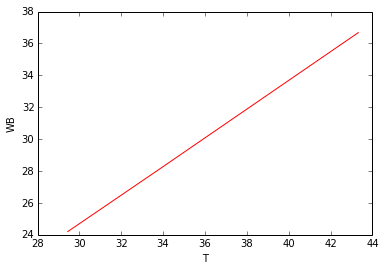

In [12]:
values = batch_WB(hygrometry.calc_sWB, [hygrometry.conv_F2C(85.), hygrometry.conv_F2C(110.), 0.01], [65., 66., 65.], [977., 978., 977.])
Tv, RHv, Pv, Vv = zip(*values)
figure()
        
plot(Tv, Vv, 'r')
xlabel('T')
ylabel('WB')
show()

Lets do the same check with RH

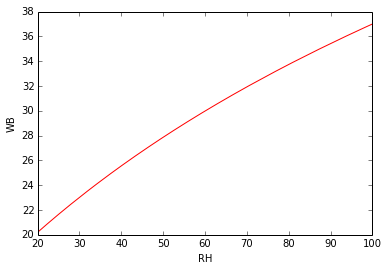

In [13]:
values = batch_WB(hygrometry.calc_sWB, [37., 38., 37.], [20, 100, 0.1], [977., 978., 977.])
Tv, RHv, Pv, Vv = zip(*values)
figure()
plot(RHv, Vv, 'r')
xlabel('RH')
ylabel('WB')
show()

Backward stability check with P

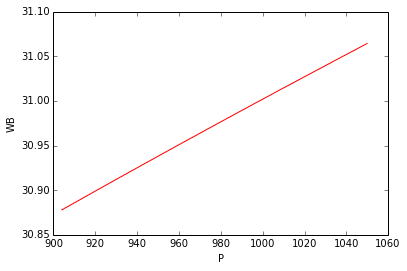

In [14]:
values = batch_WB(hygrometry.calc_sWB, [37., 38., 37.], [65., 66., 65.], [904., 1050., 0.1])
Tv, RHv, Pv, Vv = zip(*values)
figure()
        
plot(Pv, Vv, 'r')
xlabel('P')
ylabel('WB')
show()

#### Uncertainty

The algorithm I use to calculate uncertainty is also a good test for backward stability.

[0.8185512433189897, [43.244467999999905, 99.1999999999999, 914.8000000000002]]
Uncertainty: 0.818551


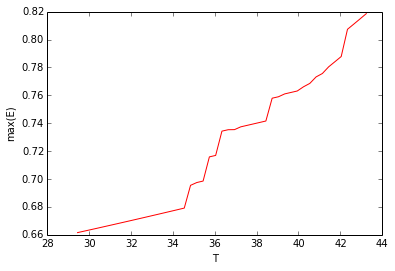

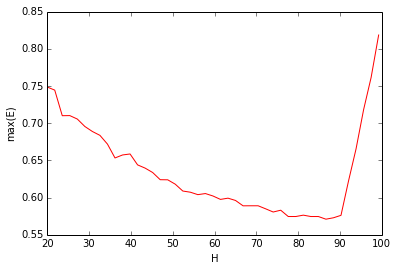

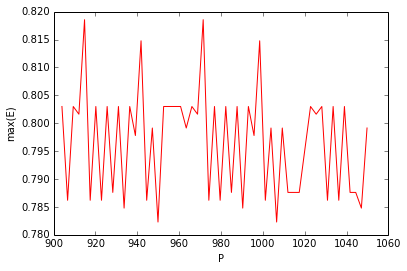

In [15]:
step_Tc = 0.3
step_RH = 1.8
step_P = 2.7
ssteps=[step_Tc, step_RH, step_P]
info, errs = calc_uncertainty(hygrometry.calc_sWB, srange, [error_Tc, error_RH, error_P], ssteps, True)
print info
print "Uncertainty: %f" % (info[0],)
plot2derrors(errs)

## Pressure Sensor Configuration

Does lack of having a pressure sensor affect our errors if pressure can vary from 17hPa from some known value?

In [16]:
def error_ambientP(P):
    return 17.0

print "Change of Wet Bulb Error in Fahrenheit caused from lack of pressure sensor"
print "T\RH| ",
for xh in frange(0., 101., 10.):
    print " %-3s " % ("%d" % (xh,),),
print
print "-"*(11*6)+"------",

frow = True
for y in frange(0., 51., hygrometry.conv_F2C(37.)):
    print
    print "%-3s | " % ("%d" % (hygrometry.conv_C2F(y),),),  
    for x in frange(0., 101., 10.):
        info, errs = calc_maxerrors(hygrometry.calc_sWB, [[y, y+1], [x, x+1], [904.0, 1050.0]], [error_Tc, error_RH, error_P], [5., 10., 2.7], True)
        merr = array(errs[3]).max()
        info, errs = calc_maxerrors(hygrometry.calc_sWB, [[y, y+1], [x, x+1], [904.0, 1050.0]], [error_Tc, error_RH, error_ambientP], [5., 10., 2.7], True)
        merr2 = array(errs[3]).max()
        print "%.2f " % (hygrometry.conv_C2F(math.fabs(merr-merr2))-32.0,),
print

Change of Wet Bulb Error in Fahrenheit caused from lack of pressure sensor
T\RH|   0     10    20    30    40    50    60    70    80    90    100 
------------------------------------------------------------------------
32  |  0.12  0.10  0.09  0.08  0.06  0.05  0.04  0.03  0.02  0.01  0.00 
37  |  0.13  0.12  0.10  0.08  0.07  0.06  0.04  0.03  0.02  0.01  0.00 
42  |  0.14  0.12  0.11  0.09  0.07  0.06  0.05  0.03  0.02  0.01  0.00 
47  |  0.15  0.13  0.11  0.09  0.08  0.06  0.05  0.03  0.02  0.01  0.00 
52  |  0.16  0.14  0.12  0.10  0.08  0.06  0.05  0.03  0.02  0.01  0.00 
57  |  0.17  0.15  0.13  0.10  0.08  0.06  0.05  0.03  0.02  0.01  0.00 
62  |  0.18  0.16  0.13  0.11  0.09  0.07  0.05  0.03  0.02  0.01  0.00 
67  |  0.19  0.17  0.14  0.11  0.09  0.07  0.05  0.03  0.02  0.01  0.00 
72  |  0.20  0.18  0.14  0.11  0.09  0.07  0.05  0.04  0.02  0.01  0.00 
77  |  0.21  0.19  0.15  0.12  0.09  0.07  0.05  0.04  0.02  0.01  0.00 
82  |  0.22  0.20  0.15  0.12  0.09  0.07  0.05  